In [1]:
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm

import scipy.stats

In [2]:
df = pd.read_csv('./batting_data_1996_2019.csv')
df.head()

,Season,Name,Team,Age,G,AB,PA,H,1B,2B,...,wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),key_mlbam
0,2002,Barry Bonds,Giants,37,143,403,612,149,70,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111188
1,2001,Barry Bonds,Giants,36,153,476,664,156,49,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111188
2,2004,Barry Bonds,Giants,39,147,373,617,135,60,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111188
3,2018,Mookie Betts,Red Sox,25,136,520,614,180,96,47,...,NaN,0.185,0.535,0.356,0.658,0.926,0.855,0.49,23.3,605141
4,2003,Barry Bonds,Giants,38,130,390,550,133,65,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111188


In [3]:
#group by player age, get batting avg
df_age_avg = df[['Age', 'H', 'AB']].groupby(['Age'], as_index=False).sum()
df_age_avg['AVG'] = df_age_avg['H'] / df_age_avg['AB']
df_age_avg['DELTA_AVG'] = 0.0
df_age_avg['PREV_AVG'] = 0.0
df_age_avg['PERCENT_CHANGE'] = 0.0

In [4]:
for i, r in df_age_avg.iterrows():
#     print(i)
    if i != 0:
        df_age_avg.at[i,'DELTA_AVG'] = df_age_avg.at[i,'AVG'] - df_age_avg.at[i-1,'AVG']
        df_age_avg.at[i,'PREV_AVG'] = df_age_avg.at[i-1,'AVG']
        
        df_age_avg.at[i,'PERCENT_CHANGE'] = df_age_avg.at[i,'DELTA_AVG']/df_age_avg.at[i,'PREV_AVG']

        
df_age_avg.head()

,Age,H,AB,AVG,DELTA_AVG,PREV_AVG,PERCENT_CHANGE
0,19,612,2292,0.267016,0.000000,0.000000,0.000000
1,20,3232,11666,0.277044,0.010029,0.267016,0.037558
2,21,8432,31390,0.268621,-0.008424,0.277044,-0.030406
3,22,24111,90180,0.267365,-0.001255,0.268621,-0.004673
4,23,41036,155813,0.263367,-0.003998,0.267365,-0.014954


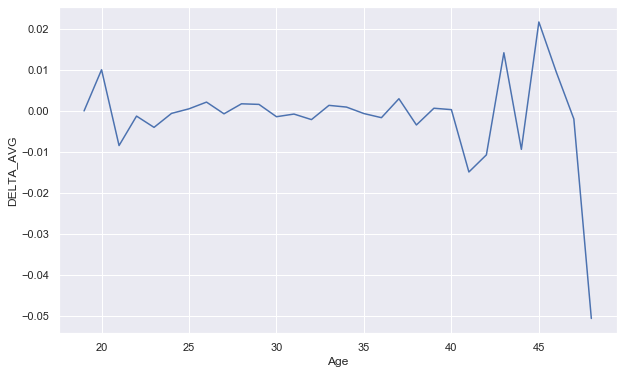

In [5]:
# explore delta of avg by age 
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = sns.lineplot(x="Age", y="DELTA_AVG", data=df_age_avg, markers=True)

In [6]:
# explore percent change by age and previous season's avg
df2 = df[['key_mlbam', 'Age', 'H', 'AB', 'AVG']]
df2['DELTA_AVG'] = float("NaN")
df2['PREV_AVG'] = float("NaN")
df2['PERCENT_CHANGE'] = float("NaN")

for i, r in df2.iterrows():
    prev = df2[ (df2.key_mlbam==r.key_mlbam) & (df2['Age']==(r['Age']-1)) ]

    if len(prev)==1:
        df2.at[i,'DELTA_AVG'] = r.AVG - prev.AVG
        df2.at[i,'PREV_AVG'] = prev.AVG

        df2.at[i,'PERCENT_CHANGE'] = df2.at[i,'DELTA_AVG']/df2.at[i,'PREV_AVG']

# remove any rows where we dont have previous season data...ex: a player's first season
df2.dropna(axis=0, how='any', inplace=True)

# remove all players that hit below 0.150 the previous season...
# realistically you arent drafting those players and some are outliers

df2 = df2[df2.PREV_AVG >= 0.150]
df2.head()

/Users/dhui/anaconda3/envs/py3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dhui/anaconda3/envs/py3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/dhui/anaconda3/envs/py3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is tr

,key_mlbam,Age,H,AB,AVG,DELTA_AVG,PREV_AVG,PERCENT_CHANGE
0,111188,37,149,403,0.370,0.042,0.328,0.128049
1,111188,36,156,476,0.328,0.022,0.306,0.071895
2,111188,39,135,373,0.362,0.021,0.341,0.061584
3,605141,25,180,520,0.346,0.082,0.264,0.310606
4,111188,38,133,390,0.341,-0.029,0.370,-0.078378


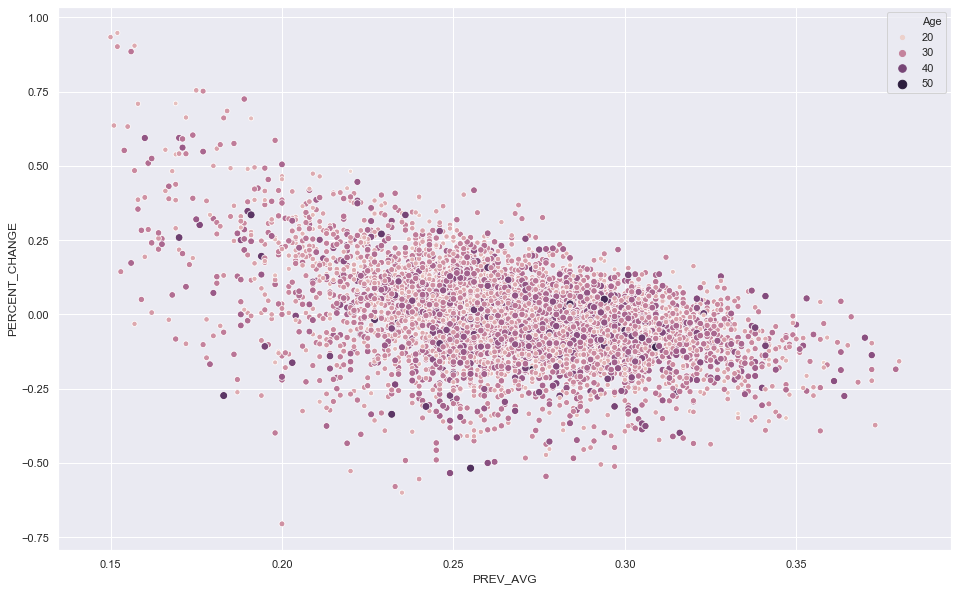

In [7]:
# show trend between percent_change based on previous season's avg and code each point by the age
fig = plt.gcf()
fig.set_size_inches(16, 10)
ax = sns.scatterplot(x="PREV_AVG", y="PERCENT_CHANGE", data=df2, size='Age', hue='Age')

# Clearly see a downward linear trend indicating that as the previous season's average gets higher, it is more likely
# that the percent change for the upcoming season will be negative

In [8]:
# Create simple linear regression model using age and previous season avg to predict percent change

mod = sm.ols(formula="PERCENT_CHANGE ~ Age + PREV_AVG", data=df2).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:         PERCENT_CHANGE   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     855.6
Date:                Wed, 18 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:28:23   Log-Likelihood:                 3517.1
No. Observations:                5922   AIC:                            -7028.
Df Residuals:                    5919   BIC:                            -7008.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6214      0.019     33.158      0.0

In [9]:
# Formulate idea...
# Because the linear model prediction for any given input will be the expectation of percent change, we can use this
# along with the coefficients of the model to generate and gaussian distribution for any given input

In [17]:
def determine_change_prob(predicted_avg, age, prev_avg, data, mod):
    ## predicted_avg:  predicted batting average for upcoming season.  
    ##                 Probability of at least this batting average occuring will be returned.
    ##
    ## age:  integer value, age of player in current season
    ## prev_avg: float, previous season's batting average for player
    ## data: pandas dataframe of all observations that trained model
    ## mod: any linear regression statsmodel with a predict function that takes in a pandas dataframe
    
    percent_change = (predicted_avg-prev_avg)/prev_avg
    
    ind = ['Age', 'PREV_AVG']
    row = [age, prev_avg] 

    # create Pandas Series with defined indexes 
    x = pd.Series(row, index = ind) 

    avg_age = np.mean(data['Age'])
    # might need to change how to get previous season's batting average among all players
    avg_prev_avg = np.mean(data['PREV_AVG'])
    
    model_mu = mod.predict(x)
    cov = np.cov(df2['Age'],data['PREV_AVG'])[0][1]
    ## formula for model variance here https://link.springer.com/content/pdf/bbm%3A978-0-585-25657-3%2F1.pdf
    model_var = mod.params[1]**2 * np.var(data['Age']) + mod.params[2]**2 * np.var(data['PREV_AVG']) + 2*mod.params[1]*mod.params[2]*cov
    model_std = np.sqrt(model_var)
    
    prob = 1-scipy.stats.norm(model_mu, model_std).cdf(percent_change)[0]
    
    return prob, predicted_avg

In [18]:
determine_change_prob(0.280, 25, 0.300, df2, mod)

(0.5057406933839175, 0.28)